In [2]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Versions of HDF5 earlier than 1.8.13 seem to give trouble
import h5py
print h5py.version.info

Summary of the h5py configuration
---------------------------------

h5py    2.5.0
HDF5    1.8.14
Python  2.7.10 (default, Sep 24 2015, 00:07:46) 
[GCC 4.4.5 20110214 (Red Hat 4.4.5-6)]
sys.platform    linux2
sys.maxsize     9223372036854775807
numpy   1.10.1



In [4]:
sys.path.insert(0, '../cbcrom')

import timedomainwaveform as tdwave
import timedomainrom as tdrom
import eobtrainingset as eob
import greedy
import empiricalinterpolation as eim
import diagnostics as diagnostics
import chebyshev as cheb

import imp
imp.reload(tdwave)
imp.reload(tdrom)
imp.reload(eob)
imp.reload(greedy)
imp.reload(eim)
imp.reload(diagnostics)
imp.reload(cheb)

<module 'chebyshev' from '../cbcrom/chebyshev.pyc'>

# Get training set

In [ ]:
training_set_dir = '/home/bdlackey/teob/teob_runs_cheb16_f10_v2'
ts_filename = '../data/teob_runs_cheb16_f10_v2_%d.hdf5'
# break up hdf5 file into 16GB chunks
memb_size=2**34-1
param_names = ['q', 'LambdaA', 'LambdaB']
ts = eob.get_eob_training_set_efficient(training_set_dir, ts_filename, memb_size=memb_size, regular_grid=True, 
                          param_names=param_names, 
                          t_transition=-1000.0, samples_per_cycle=2.0, dt=0.1)
ts.close()

In [5]:
ts_filename = '../data/teob_runs_cheb16_f10_v2_%d.hdf5'
memb_size=2**34-1
ts = tdwave.load_hdf5_time_domain_waveform_set(ts_filename, memb_size=memb_size)

# Test training set

[  5.00000000e-01   5.00000000e+01   4.78602501e+03]


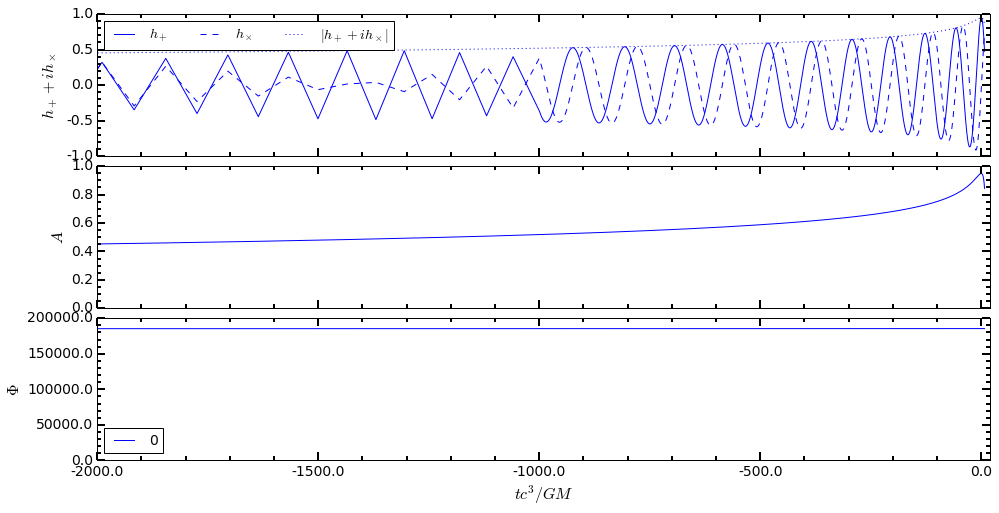

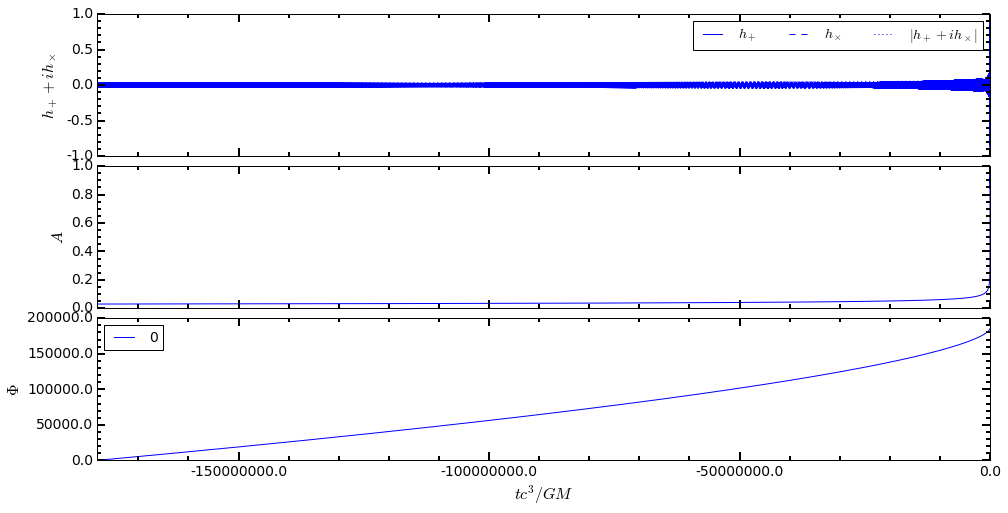

In [5]:
i=13
waveforms = ts.get_waveform_data(i)
print ts.get_waveform_data(i, data='parameters')

xlim=[-2000, 20]
fig = plt.figure(figsize=(16, 8))
tdwave.plot_time_domain_waveform_list(fig, waveforms, imag=True, mag=True, 
                               xlim=xlim, xlabel=r'$tc^3/GM$',
                               ylabel_pol=r'$h_+ + i h_\times$', 
                               ylabel_amp=r'$A$', ylabel_phase=r'$\Phi$', 
                               pol_legend=True)

xlim=[waveforms.time[0], waveforms.time[-1]]
fig = plt.figure(figsize=(16, 8))
tdwave.plot_time_domain_waveform_list(fig, waveforms, imag=True, mag=True, 
                               xlim=xlim, xlabel=r'$tc^3/GM$',
                               ylabel_pol=r'$h_+ + i h_\times$', 
                               ylabel_amp=r'$A$', ylabel_phase=r'$\Phi$', 
                               pol_legend=True)

(-50, 10)

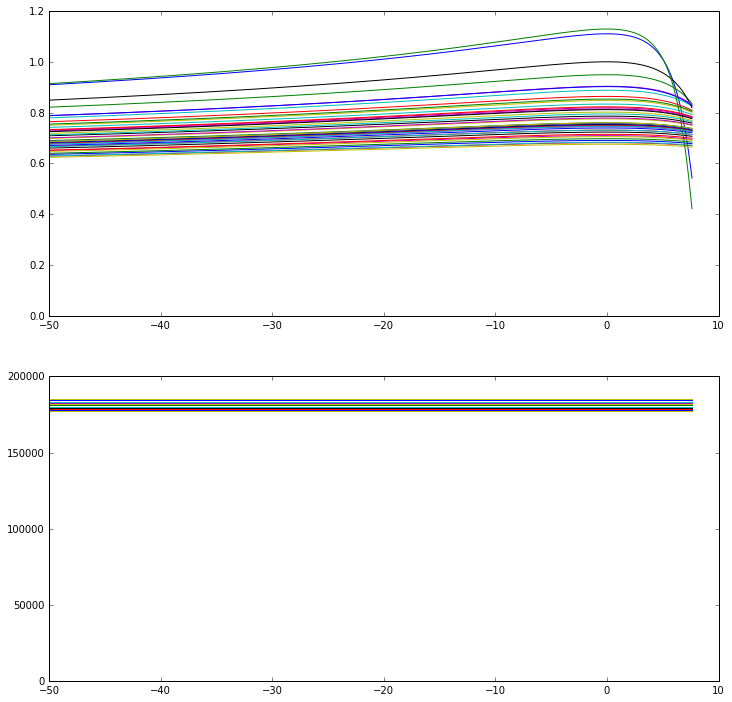

In [6]:
fig = plt.figure(figsize=(12, 12))

axes = fig.add_subplot(211)
for i in range(0, ts.get_len(), 100):
    axes.plot(ts.get_waveform_data(i).time, ts.get_waveform_data(i).amp, marker='')
axes.set_xlim([-50, 10])

axes = fig.add_subplot(212)
for i in range(0, ts.get_len(), 100):
    axes.plot(ts.get_waveform_data(i).time, ts.get_waveform_data(i).phase, marker='')
axes.set_xlim([-50, 10])

# Make reduced basis

### Greedy algorithm for amplitude

In [30]:
epsilon = 1.0e-15

# Initialize the ReducedBasis object
add = tdwave.add_amp
subtract = tdwave.subtract_amp
scalar_multiply = tdwave.scalar_multiply_amp
#inner_product = tdwave.inner_product_amp_simps
#inner_product = tdwave.inner_product_amp
inner_product = tdwave.inner_product_amp_samples
get_waveform = ts.get_waveform_data
ts_params = ts.get_parameters()
rbamprun = greedy.ReducedBasis(add, subtract, scalar_multiply, inner_product, get_waveform, ts_params)

# Standard method
rbamprun.generate_reduced_basis(epsilon, ts_istart=0, Nbases=None)

1.0
0.0102785807384
0.000312137808281
0.000104706069239
1.10987231872e-06
5.43599517178e-07
2.82877798297e-07
9.18030570451e-08
1.57224008257e-08
4.74921368898e-09
1.33465416496e-09
1.30478960969e-10
4.35546043676e-11
1.92904581198e-11
2.57782684088e-12
5.20250509339e-13
1.25122134875e-13
5.71764857682e-14
2.63122856836e-14
4.10782519111e-15
9.99200722163e-16


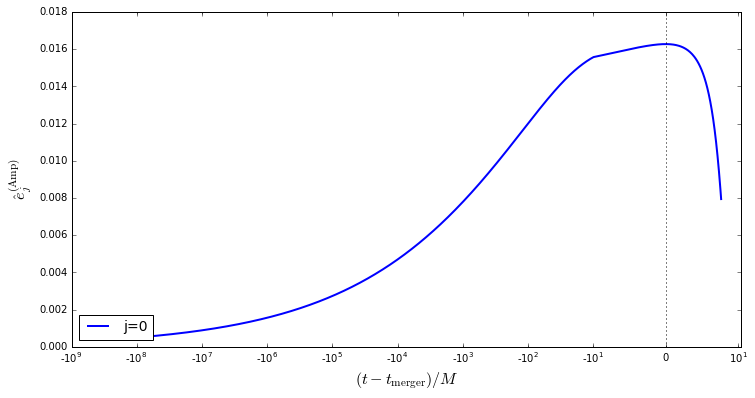

In [45]:
fig = plt.figure(figsize=(12, 6))

axes = fig.add_subplot(111)
for j in range(1):
    axes.plot(rbamprun.rb[j].time, rbamprun.rb[j].amp, lw=2, label='j='+str(j))
axes.axhline(0.0, color='k', ls=':')
axes.axvline(0.0, color='k', ls=':')
axes.set_xlim([-1.0e9, 11.0])
#axes.set_ylim([-1.1, 1.1])
axes.set_xscale('symlog', linthreshx=10.0)
#axes.set_yscale('symlog', linthreshx=0.0001)

axes.set_xlabel(r'$(t-t_{\rm merger})/M$', fontsize=16)
axes.set_ylabel(r'$\hat e^{\rm (Amp)}_j$', fontsize=16)
axes.legend(fontsize=14, loc='lower left', ncol=3)

In [47]:
# Store reduced basis in HDF5TimeDomainWaveformSet object
filename = '../data/teob_rbamp_smallq_cheb_16_%d.hdf5'
param_names = ['q', 'LambdaA', 'LambdaB']
rbamp = tdwave.HDF5TimeDomainWaveformSet(filename, mode='x', memb_size=memb_size)
#rbamp = tdwave.HDF5TimeDomainWaveformSet(filename)
rbamp.set_parameter_names(param_names)
rbamp.set_grid_shape(shape=None)
rbamp.add_waveform_list(rbamprun.rb, rbamprun.rb_params)
rbamp.close()

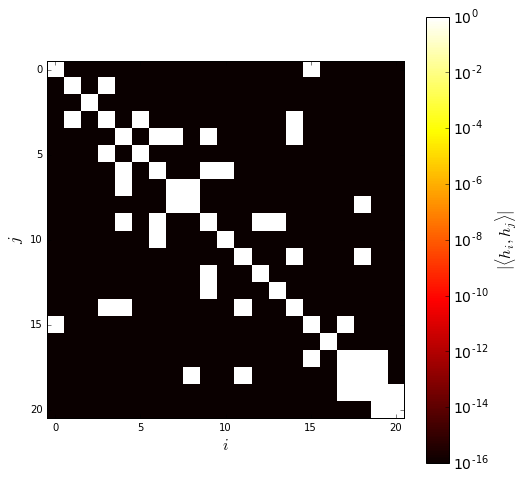

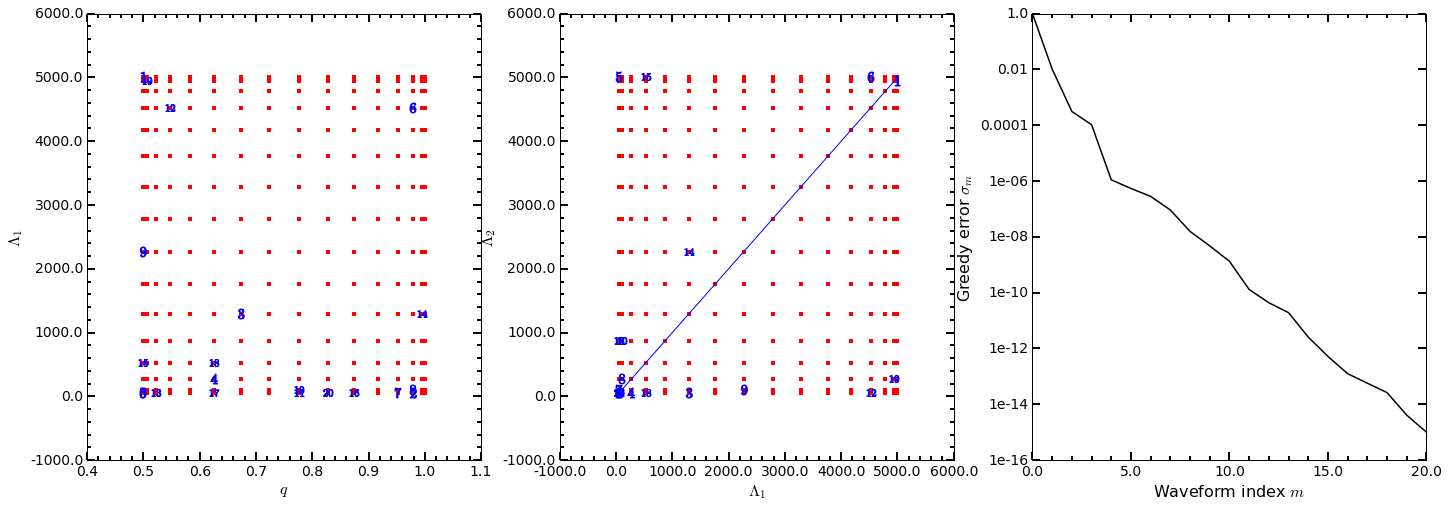

In [50]:
inner = diagnostics.check_orthonormality(rbamprun.rb, inner_product)

fig = plt.figure(figsize=(24, 8))

axes = fig.add_subplot(131)
diagnostics.plot_parameters(axes, 0, 1, ts_params=rbamprun.ts_params, rb_params=rbamprun.rb_params, 
                xlabel=r'$q$', ylabel=r'$\Lambda_1$')

axes = fig.add_subplot(132)
diagnostics.plot_parameters(axes, 1, 2, ts_params=rbamprun.ts_params, rb_params=rbamprun.rb_params, 
                xlabel=r'$\Lambda_1$', ylabel=r'$\Lambda_2$')
axes.plot([0, 5000], [0, 5000])

axes = fig.add_subplot(133)
diagnostics.plot_greedy_error(axes, rbamprun.sigma_list)

### Greedy algorithm for phase

In [ ]:
import scipy.integrate

# def inner_product_phase_weighted(h1, h2):
#     """Use Simpson's rule to
#     evaluate the inner product < phi1, phi2 > = int_tL^tH dt phi1(t) phi2(t).
#     Assumes h1 and h2 have the same (1) length, (2) start_time, (3) delta_t.
#     """
#     #check_waveform_consistency(h1, h2)
#     t = h1.time
#     t0 = t[0]
#     weight = t-t0+1.0
#     integrand = weight*h1.phase*h2.phase
#     return scipy.integrate.simps(integrand, x=h1.time)

def inner_product_phase_weighted(h1, h2):
    """Use Simpson's rule to
    evaluate the inner product < phi1, phi2 > = int_tL^tH dt phi1(t) phi2(t).
    Assumes h1 and h2 have the same (1) length, (2) start_time, (3) delta_t.
    """
    #check_waveform_consistency(h1, h2)
    t = h1.time
    #weight = np.array([1.0e-8 if t[i]<-1.0e4 else 1.0 for i in range(len(t))])
    #weight = np.array([0.0 if t[i]<-1.0e3 else 1.0 for i in range(len(t))])
    #print weight
    t0 = t[0]
    weight = t-t0+1.0
    #print weight
    integrand = weight*h1.phase*h2.phase
    return scipy.integrate.simps(integrand, x=h1.time)
    

def abs_max_phase_func(h):
    """
    """
    return np.max(np.abs(h.phase))

In [ ]:
def inner_product_phase_weighted_2(h1, h2):
    """Evaluate the inner product < phi1, phi2 > = int_tL^tH dt phi1(t) phi2(t).
    Assumes h1 and h2 have the same (1) length, (2) start_time, (3) delta_t.
    """
    #check_waveform_consistency(h1, h2)
    t = h1.time
    #weight = np.array([1.0e-8 if t[i]<-1.0e4 else 1.0 for i in range(len(t))])
    weight = np.array([0.0 if t[i]<-1.0e3 else 1.0 for i in range(len(t))])
    integrand = weight*h1.phase*h2.phase
    diff = np.array([h1.time[i+1]-h1.time[i] for i in range(len(h1.time)-1)])
    sum_neighbors = np.array([integrand[i]+integrand[i+1] for i in range(len(integrand)-1)])
    return 0.5*np.sum( diff * sum_neighbors )

def inner_product_phase_weighted_3(h1, h2):
    """Evaluate the inner product < phi1, phi2 > = int_tL^tH dt phi1(t) phi2(t).
    Assumes h1 and h2 have the same (1) length, (2) start_time, (3) delta_t.
    """
    #check_waveform_consistency(h1, h2)
    t = h1.time
    t0 = t[0]
    weight = 1.0/(t-t0+1.0)
    #print weight
    integrand = weight*h1.phase*h2.phase
    
    diff = np.array([h1.time[i+1]-h1.time[i] for i in range(len(h1.time)-1)])
    sum_neighbors = np.array([integrand[i]+integrand[i+1] for i in range(len(integrand)-1)])
    return 0.5*np.sum( diff * sum_neighbors )

def inner_product_phase_weighted_4(h1, h2):
    """Evaluate the inner product < phi1, phi2 > = int_tL^tH dt phi1(t) phi2(t).
    Assumes h1 and h2 have the same (1) length, (2) start_time, (3) delta_t.
    """
    #check_waveform_consistency(h1, h2)
    t = h1.time
    t0 = t[0]
    weight = (t-t0+1.0)**2
    #print weight
    integrand = weight*h1.phase*h2.phase
    return np.sum( integrand )

In [ ]:
h1 = ts.get_waveform_data(0)
h2 = ts.get_waveform_data(0)
t = h1.time
weight = np.array([0.0 if t[i]<-1.0e3 else 1.0 for i in range(len(t))])

In [ ]:
h1.phase*h2.phase

In [ ]:
np.min(weight*h1.phase*h2.phase)

In [ ]:
print tdwave.inner_product_phase_simps(h1, h2)
print inner_product_phase_weighted(h1, h2)
print inner_product_phase_weighted_2(h1, h2)
print inner_product_phase_weighted_3(h1, h2)
print inner_product_phase_weighted_4(h1, h2)

In [16]:
epsilon = 1.0e-15

# Initialize the ReducedBasis object
add = tdwave.add_phase
subtract = tdwave.subtract_phase
scalar_multiply = tdwave.scalar_multiply_phase
#inner_product = inner_product_phase_weighted
#inner_product = inner_product_phase_weighted_2
#inner_product = inner_product_phase_weighted_3
#inner_product = inner_product_phase_weighted_4
inner_product = tdwave.inner_product_phase_samples
#inner_product = tdwave.inner_product_phase_simps
#inner_product = tdwave.inner_product_phase
#abs_max = abs_max_phase_func
get_waveform = ts.get_waveform_data
ts_params = ts.get_parameters()
rbphaserun = greedy.ReducedBasis(add, subtract, scalar_multiply, inner_product, get_waveform, ts_params)

# Standard method
rbphaserun.generate_reduced_basis(epsilon, ts_istart=0, Nbases=8)

1.0
4.3964651919e-08
4.80797957003e-10
1.721223164e-11
9.55902024202e-14
5.99520433298e-15
8.881784197e-16


In [28]:
# Store reduced basis in HDF5TimeDomainWaveformSet object
filename = '../data/teob_rbphase_smallq_cheb_16_%d.hdf5'
param_names = ['q', 'LambdaA', 'LambdaB']
rbphase = tdwave.HDF5TimeDomainWaveformSet(filename, mode='x', memb_size=memb_size)
rbphase.set_parameter_names(param_names)
rbphase.set_grid_shape(shape=None)
rbphase.add_waveform_list(rbphaserun.rb, rbphaserun.rb_params)
rbphase.close()

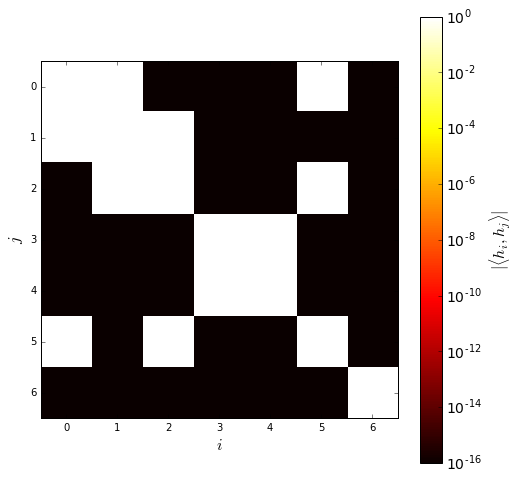

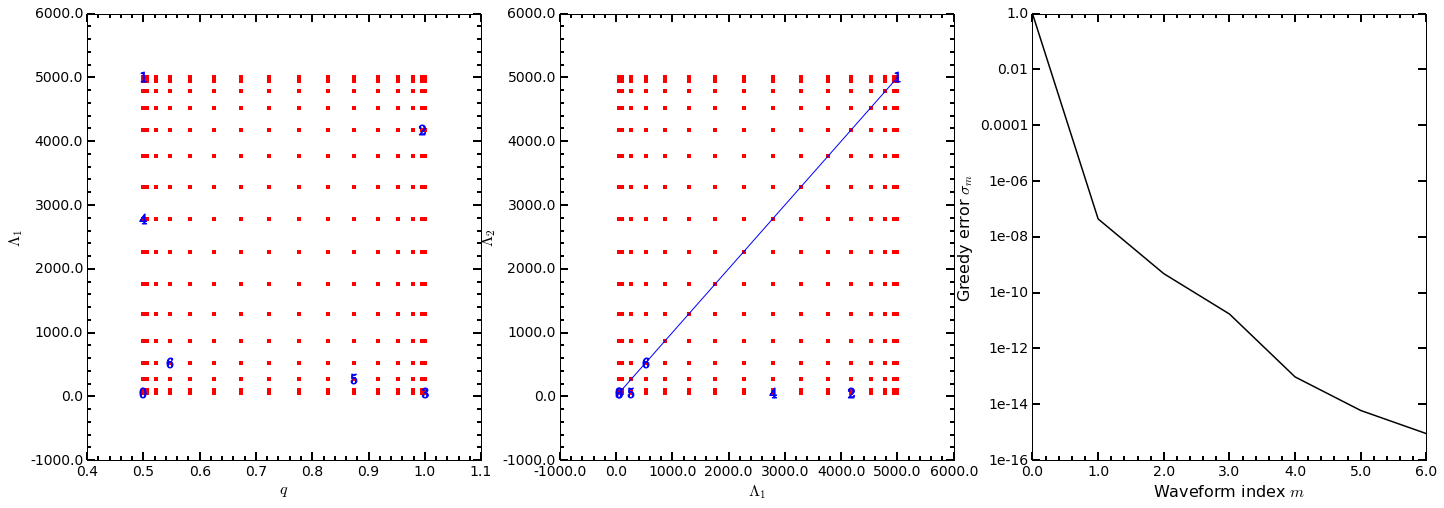

In [29]:
inner = diagnostics.check_orthonormality(rbphaserun.rb, inner_product)

fig = plt.figure(figsize=(24, 8))

axes = fig.add_subplot(131)
diagnostics.plot_parameters(axes, 0, 1, ts_params=rbphaserun.ts_params, rb_params=rbphaserun.rb_params, 
                xlabel=r'$q$', ylabel=r'$\Lambda_1$')

axes = fig.add_subplot(132)
diagnostics.plot_parameters(axes, 1, 2, ts_params=rbphaserun.ts_params, rb_params=rbphaserun.rb_params, 
                xlabel=r'$\Lambda_1$', ylabel=r'$\Lambda_2$')
axes.plot([0, 5000], [0, 5000])

axes = fig.add_subplot(133)
diagnostics.plot_greedy_error(axes, rbphaserun.sigma_list)

# Generate empirical nodes

In [6]:
memb_size=2**34-1

filename = '../data/teob_rbamp_smallq_cheb_16_%d.hdf5'
rbamp = tdwave.load_hdf5_time_domain_waveform_set(filename, memb_size=memb_size)

filename = '../data/teob_rbphase_smallq_cheb_16_%d.hdf5'
rbphase = tdwave.load_hdf5_time_domain_waveform_set(filename, memb_size=memb_size)

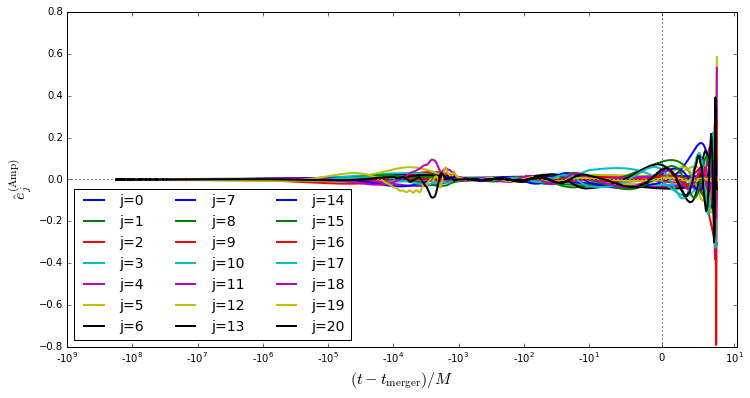

In [10]:
fig = plt.figure(figsize=(12, 6))

axes = fig.add_subplot(111)
for j in range(rbamp.get_len()):
    h = rbamp.get_waveform_data(j)
    axes.plot(h.time, h.amp, lw=2, label='j='+str(j))
axes.axhline(0.0, color='k', ls=':')
axes.axvline(0.0, color='k', ls=':')
axes.set_xlim([-1.0e9, 11.0])
axes.set_ylim([-0.8, 0.8])
axes.set_xscale('symlog', linthreshx=10.0)
#axes.set_yscale('symlog', linthreshx=0.0001)

axes.set_xlabel(r'$(t-t_{\rm merger})/M$', fontsize=16)
axes.set_ylabel(r'$\hat e^{\rm (Amp)}_j$', fontsize=16)
axes.legend(fontsize=14, loc='lower left', ncol=3)

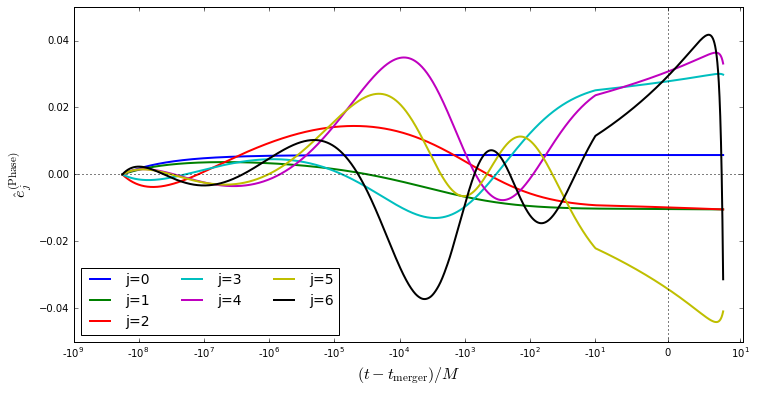

In [11]:
fig = plt.figure(figsize=(12, 6))

axes = fig.add_subplot(111)
for j in range(rbphase.get_len()):
    h = rbphase.get_waveform_data(j)
    axes.plot(h.time, h.phase, lw=2, label='j='+str(j))
axes.axhline(0.0, color='k', ls=':')
axes.axvline(0.0, color='k', ls=':')
axes.set_xlim([-1.0e9, 11.0])
#axes.set_ylim([-0.1, 0.1])
axes.set_xscale('symlog', linthreshx=10.0)
#axes.set_yscale('symlog', linthreshx=0.01)

axes.set_xlabel(r'$(t-t_{\rm merger})/M$', fontsize=16)
axes.set_ylabel(r'$\hat e^{\rm (Phase)}_j$', fontsize=16)
axes.legend(fontsize=14, loc='lower left', ncol=3)
fig.savefig('/home/bdlackey/public_html/ROM/RBphase.pdf', format='pdf', transparent=True, bbox_inches='tight')

In [16]:
empirical_node_indices_amp, Bamp_j = tdrom.empirical_interpolation_for_time_domain_waveform(rbamp, 'amp')
empirical_node_indices_phase, Bphase_j = tdrom.empirical_interpolation_for_time_domain_waveform(rbphase, 'phase')

In [54]:
# Store interpolating functions in HDF5TimeDomainWaveformSet object

# Amplitude
memb_size=2**26-1
filename = '../data/Bamp_%d.hdf5'
Bamp = tdwave.HDF5TimeDomainWaveformSet(filename, mode='x', memb_size=memb_size)
Bamp.set_grid_shape(shape=None)
Bamp.set_parameter_names(['q', 'LambdaA', 'LambdaB'])
Bamp.add_waveform_list(Bamp_j, [[0.0, 0.0, 0.0]]*len(Bamp_j))
Bamp.close()

# Phase
filename = '../data/Bphase_%d.hdf5'
Bphase = tdwave.HDF5TimeDomainWaveformSet(filename, mode='x', memb_size=memb_size)
Bphase.set_grid_shape(shape=None)
Bphase.set_parameter_names(['q', 'LambdaA', 'LambdaB'])
Bphase.add_waveform_list(Bphase_j, [[0.0, 0.0, 0.0]]*len(Bphase_j))
Bphase.close()

In [12]:
memb_size=2**26-1

filename = '../data/Bamp_%d.hdf5'
Bamp = tdwave.load_hdf5_time_domain_waveform_set(filename, memb_size=memb_size)

filename = '../data/Bphase_%d.hdf5'
Bphase = tdwave.load_hdf5_time_domain_waveform_set(filename, memb_size=memb_size)

In [13]:
Bamp_list = [Bamp.get_waveform_data(i) for i in range(Bamp.get_len())]
Bphase_list = [Bphase.get_waveform_data(i) for i in range(Bphase.get_len())]

In [14]:
Bamp.close()
Bphase.close()

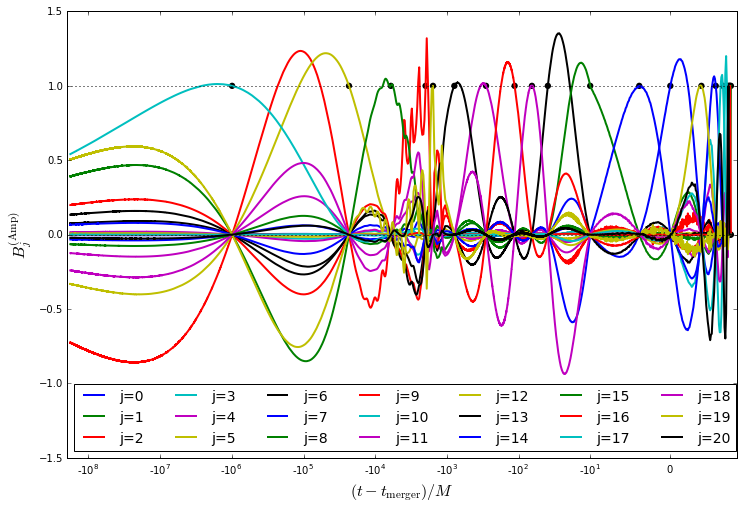

In [19]:
fig = plt.figure(figsize=(12, 8))
axes = fig.add_subplot(111)

for j in range(len(Bamp_list)):
    h = Bamp_list[j]
    axes.plot(h.time, h.amp, lw=2, label='j='+str(j))

axes.axhline(y=0.0, color='k', ls=':')
axes.axhline(y=1.0, color='k', ls=':')
axes.set_xlim([-1.0e9, 11.0])
axes.set_xlim([1.1*h.time[0], 1.1*h.time[-1]])
axes.set_xscale('symlog', linthreshx=10.0)

indices = empirical_node_indices_amp
htime = h.time[indices]
axes.scatter(htime, 0*htime, marker='o', c='k', s=40, edgecolor='none')
axes.scatter(htime, 0*htime+1, marker='o', c='k', s=40, edgecolor='none')

axes.set_xlabel(r'$(t-t_{\rm merger})/M$', fontsize=16)
axes.set_ylabel(r'$B^{\rm (Amp)}_j$', fontsize=16)
axes.legend(fontsize=14, loc='lower left', ncol=7)

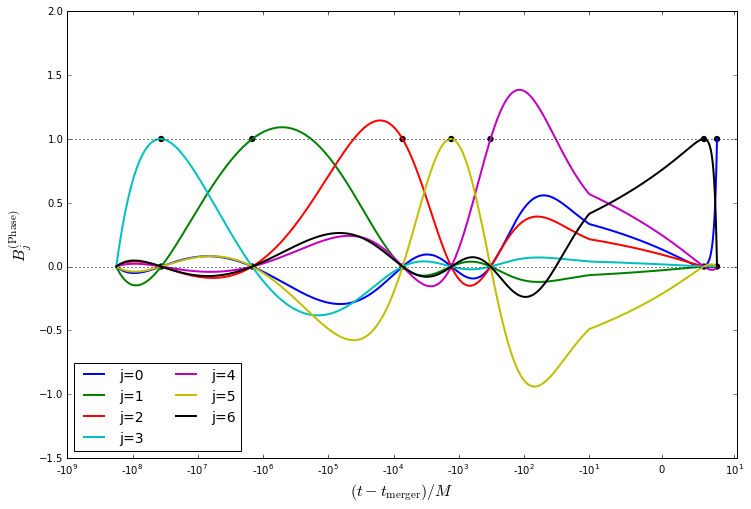

In [20]:
fig = plt.figure(figsize=(12, 8))
axes = fig.add_subplot(111)

for j in range(len(Bphase_list)):
    h = Bphase_list[j]
    axes.plot(h.time, h.phase, lw=2, label='j='+str(j))

axes.axhline(y=0.0, color='k', ls=':')
axes.axhline(y=1.0, color='k', ls=':')
axes.set_xlim([-1.0e9, 11.0])
axes.set_xscale('symlog', linthreshx=10.0)

indices = empirical_node_indices_phase
htime = h.time[indices]
axes.scatter(htime, 0*htime, marker='o', c='k', s=40, edgecolor='none')
axes.scatter(htime, 0*htime+1, marker='o', c='k', s=40, edgecolor='none')

axes.set_xlabel(r'$(t-t_{\rm merger})/M$', fontsize=16)
axes.set_ylabel(r'$B^{\rm (Phase)}_j$', fontsize=16)
axes.legend(fontsize=14, loc='lower left', ncol=3)
fig.savefig('/home/bdlackey/public_html/ROM/Bphase.pdf', format='pdf', transparent=True, bbox_inches='tight')

# Interpolate training set amp and phase at empirical nodes

In [65]:
# This extracts each training set waveform from the HD, so it will take several minutes.
train_amp_at_nodes = tdrom.waveform_data_at_empirical_nodes(ts, empirical_node_indices_amp, 'amp')
train_phase_at_nodes = tdrom.waveform_data_at_empirical_nodes(ts, empirical_node_indices_phase, 'phase')

In [66]:
param_grid = ts.get_parameter_grid()

# Turn amp-at-empirical-nodes to list-of-grids
shape = tuple(ts.grid_shape)
Nnodes = len(train_amp_at_nodes[0])
train_amp_grid_list = []
for i in range(Nnodes):
    amp_grid = train_amp_at_nodes[:, i].reshape(shape)
    train_amp_grid_list.append(amp_grid)
    
# Turn phase-at-empirical-nodes to list-of-grids
shape = tuple(ts.grid_shape)
Nnodes = len(train_phase_at_nodes[0])
train_phase_grid_list = []
for i in range(Nnodes):
    phase_grid = train_phase_at_nodes[:, i].reshape(shape)
    train_phase_grid_list.append(phase_grid)

In [67]:
params_min = param_grid[0, 0, 0]
params_max = param_grid[-1, -1, -1]
amp_coeff_list = cheb.chebyshev_coefficient3d_list_generator(train_amp_grid_list, params_min, params_max)
phase_coeff_list = cheb.chebyshev_coefficient3d_list_generator(train_phase_grid_list, params_min, params_max)

In [68]:
print len(amp_coeff_list), amp_coeff_list[0].shape
print len(phase_coeff_list), phase_coeff_list[0].shape

21 (16, 16, 16)
7 (16, 16, 16)


In [69]:
filename = '../data/amp_coeffs.hdf5'
coefficients_list = amp_coeff_list
cheb.save_chebyshev_coefficients_list(filename, coefficients_list, params_min, params_max)

filename = '../data/phase_coeffs.hdf5'
coefficients_list = phase_coeff_list
cheb.save_chebyshev_coefficients_list(filename, coefficients_list, params_min, params_max)

# Load ROM

In [70]:
memb_size=2**26-1
Bamp_filename = '../data/Bamp_%d.hdf5'
Bphase_filename = '../data/Bphase_%d.hdf5'
ampcoeff_filename = '../data/amp_coeffs.hdf5'
phasecoeff_filename = '../data/phase_coeffs.hdf5'
rom = tdrom.load_reduced_order_model_time_domain_waveform(Bamp_filename, Bphase_filename, memb_size,
                                                  ampcoeff_filename, phasecoeff_filename)

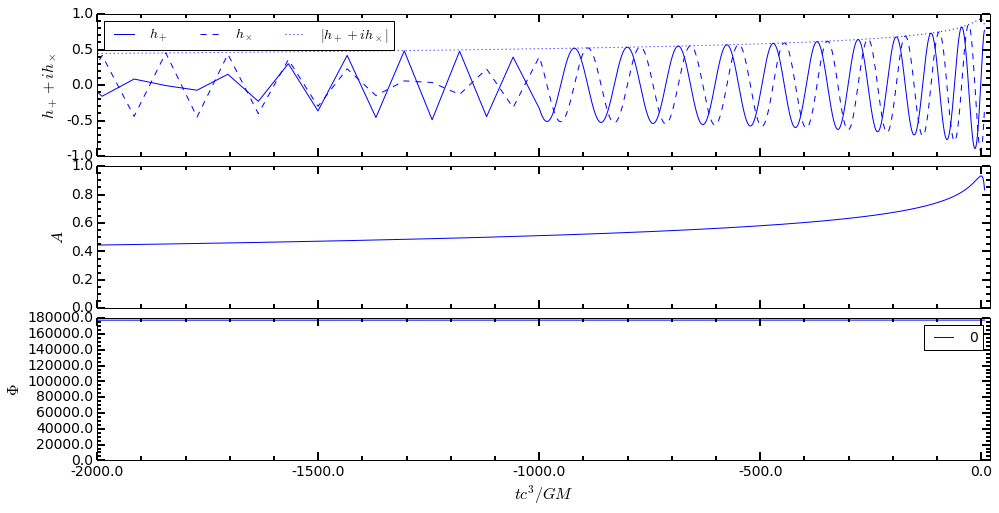

In [71]:
params = [0.9, 501, 500]
waveforms = rom.evaluate(params)

xlim=[-2000, 20]
fig = plt.figure(figsize=(16, 8))
tdwave.plot_time_domain_waveform_list(fig, waveforms, imag=True, mag=True, 
                               xlim=xlim, xlabel=r'$tc^3/GM$',
                               ylabel_pol=r'$h_+ + i h_\times$', 
                               ylabel_amp=r'$A$', ylabel_phase=r'$\Phi$', 
                               pol_legend=True)

In [72]:
len(waveforms.time)

69072